#Author Information
Name: Eugene Su

Email: su.eugene@gmail.com

GitHub: https://github.com/EugenePig

Date: 2023/05/09

Essential Functions:
1.   K-Fold Cross Validation
2.   Learning Curve
3.   Confusion Matrix
4.   Feature Map


In [1]:
import os
if not os.path.exists('data.zip'):
    !gdown --fuzzy https://drive.google.com/file/d/111OewV08mLy2rwcr80IaRLCt2Ik5QDdC/view?usp=sharing

!unzip -o data.zip

Downloading...
From: https://drive.google.com/uc?id=111OewV08mLy2rwcr80IaRLCt2Ik5QDdC
To: /content/data.zip
100% 50.9M/50.9M [00:00<00:00, 78.6MB/s]
Archive:  data.zip
   creating: data/0/
  inflating: data/0/1.png            
  inflating: data/0/10.png           
  inflating: data/0/100.png          
  inflating: data/0/101.png          
  inflating: data/0/102.png          
  inflating: data/0/103.png          
  inflating: data/0/104.png          
  inflating: data/0/105.png          
  inflating: data/0/106.png          
  inflating: data/0/107.png          
  inflating: data/0/108.png          
  inflating: data/0/109.png          
  inflating: data/0/11.png           
  inflating: data/0/110.png          
  inflating: data/0/111.png          
  inflating: data/0/112.png          
  inflating: data/0/113.png          
  inflating: data/0/114.png          
  inflating: data/0/115.png          
  inflating: data/0/116.png          
  inflating: data/0/117.png          
  inflating: 

In [2]:
#!/usr/bin/env python
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset
from sklearn.model_selection import KFold
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay

The CustomDataset class is a PyTorch Dataset subclass that loads image data
from a specified directory and applies an optional transformation to each
image.

**Parameters**:

* root_dir (str): The root directory where the image data is stored.

* transform (callable, optional): A function or a transform object that takes
in an image and returns a transformed version of it. The default value is
None, which means that no transformation will be applied.

In [3]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.dataset = ImageFolder(root_dir, transform=transform)

    def __getitem__(self, index):
        image, label = self.dataset[index]
        return image, label

    def __len__(self):
        return len(self.dataset)

This function is a custom collate function used to process data in the
PIL.Image.Image format. It converts the images in the batch into tensors
using the torchvision.transforms.ToTensor() function, and stores the labels
in a separate tensor. Finally, it returns a tuple of two tensors, one
containing the processed images, and the other containing their corresponding
labels.

**Input**:

batch: A list of tuples, where each tuple contains an image in the
PIL.Image.Image format and its corresponding label.

**Output**:

A tuple of two tensors:

* images: A tensor of shape (batch_size, channels, height, width) containing
the processed images.

* labels: A tensor of shape (batch_size,) containing the labels for each image
in the batch.

In [4]:
def custom_collate_fn(batch):
    images = []
    labels = []
    for image, label in batch:
        images.append(transforms.ToTensor()(image))
        labels.append(label)
    return torch.stack(images), torch.tensor(labels)

This function evaluates the performance of a given PyTorch model on a
provided dataset using a data loader.

**Parameters**:

* model: The PyTorch model to be evaluated.

* data_loader: A PyTorch data loader that provides the dataset for evaluation.

* device: The device (CPU or GPU) on which the evaluation should be performed.

In [5]:
def evaluation(model, data_loader, device):
    true_labels = []
    predicted_labels = []

    model.eval()
    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            true_labels += target.tolist()
            predicted_labels += predicted.tolist()

    accuracy = accuracy_score(true_labels, predicted_labels) * 100.
    recall = recall_score(true_labels, predicted_labels, pos_label=0) * 100.
    precision = precision_score(true_labels, predicted_labels, pos_label=0) * 100.

    # Calculate the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    return accuracy, recall, precision, cm

This function plots the learning curve for a given fold of a machine learning
model. It takes three inputs, the fold number, train accuracies and test
accuracies. The function then plots these accuracies against the number
of epochs and displays the resulting graph.

**Parameters**:

* fold (int): The fold number for the learning curve to be plotted.

* train_accuracies (list): A list of the train accuracies for each epoch.

* test_accuracies (list): A list of the test accuracies for each epoch.

In [6]:
def plot_learning_curve(fold, train_accuracies, test_accuracies):
    plt.figure()
    plt.plot(train_accuracies, label='train accuracy')
    plt.plot(test_accuracies, label='test accuracy')
    plt.legend()
    plt.title('Fold-{} Learning Curve'.format(fold + 1))
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

This API function sets a hook on a PyTorch module and saves the feature maps
of the input tensor for that module. The feature maps are stored in a global
variable called "feature_maps".

**Parameters**:

* module: A PyTorch module object. The hook will be set on this module.

* input: The input tensor to the module. The feature maps of this tensor will be saved.

* output: The output tensor from the module. This parameter is not used in this function.

In [7]:
feature_maps = None
def hook(module, input, output):
    global feature_maps
    feature_maps = input[0]

This API function plots the feature maps of an input tensor. The feature maps
are saved in a PyTorch tensor and are converted to a NumPy array before
being plotted. The function displays a grid of images, where each image
corresponds to a feature map in the input tensor.

**Parameters**:

* feature_maps: A PyTorch tensor containing the feature maps. The shape of the
tensor should be (batch_size, num_feature_maps, height, width), where
batch_size is the number of images in the batch, num_feature_maps is the
number of feature maps in the tensor, and height and width are the dimensions
of each feature map.

* batch_id: The index of the image in the batch for which to plot the feature
maps. This should be an integer between 0 and batch_size - 1.

In [8]:
def plot_feature_map(feature_maps, batch_id):
    feature_maps = feature_maps.detach().cpu().numpy()
    print('Dimension of feature maps = {}'.format(feature_maps.shape))
    print('Plot feature maps of Image {}'.format(batch_id))
    NUM_ROW = 8
    NUM_COL = 8
    fig, axes = plt.subplots(NUM_ROW, NUM_COL, figsize=(NUM_COL * 1.5, NUM_ROW * 1.5))
    for idx in range(NUM_ROW * NUM_COL):
        ax = axes[idx // NUM_COL, idx % NUM_COL]
        ax.imshow(feature_maps[batch_id, idx])
        ax.set_title('{}'.format(idx))

    plt.tight_layout()
    plt.show()

# Main loop function

In [9]:
def main():
    # Check if CUDA is available, use CPU otherwise
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Define training parameters
    batch_size = 32
    num_epochs = 10
    learning_rate = 0.001

    # Load the dataset
    dataset = CustomDataset('data')
    num_samples = len(dataset)

    # Define the k value for k-fold cross-validation
    k = 5

    # Create an instance of k-fold cross-validation
    kfold = KFold(n_splits=k, shuffle=True)

    # Perform k-fold cross-validation
    for fold, (train_ids, test_ids) in enumerate(kfold.split(range(num_samples))):
        # Save training and test accuracy for each fold
        train_accuracies = []
        test_accuracies = []

        # Create training and test subsets for each fold
        train_subset = Subset(dataset, train_ids)
        test_subset = Subset(dataset, test_ids)

        # Create data loaders for each subset
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
        test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

        # Define the ResNet18 model
        model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        model.avgpool.register_forward_hook(hook)
        num_classes = 2
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
        model = model.to(device)

        # Define the optimizer and the loss function
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()

        # Train the model
        print('Start Fold-{} training'.format(fold + 1))
        for epoch in range(num_epochs):
            train_loss = 0.0
            model.train()
            for batch_idx, (data, target) in enumerate(train_loader):
                data = data.to(device)
                target = target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                train_loss += loss.item() * data.size(0)
                loss.backward()
                optimizer.step()

            train_loss /= len(train_loader.dataset)

            # Evaluate the model
            train_accuracy, _, _, _ = evaluation(model, train_loader, device)
            test_accuracy, recall, precision, cm = evaluation(model, test_loader, device)

            # Save training and test accuracy for each fold
            train_accuracies.append(train_accuracy)
            test_accuracies.append(test_accuracy)

            # Print the training progress for each epoch
            print('Fold [{}/{}], Epoch [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.2f}, Test Accuracy: {:.2f}%'.format(
                    fold + 1, k, epoch + 1, num_epochs, train_loss, train_accuracy, test_accuracy))

        # Plot the confusion matrix
        cmd = ConfusionMatrixDisplay(cm, display_labels=['defect', 'non-defect'])
        cmd.plot()
        cmd.ax_.set_title('Fold-{}, Recall: {:.2f} %, Precision: {:.2f} %'.format(fold + 1, recall, precision))

        # Plot the learning curve for each fold
        plot_learning_curve(fold, train_accuracies, test_accuracies)

# Call main loop function

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 192MB/s]


Start Fold-1 training
Fold [1/5], Epoch [1/10], Train Loss: 0.9961, Train Accuracy: 59.58, Test Accuracy: 55.00%
Fold [1/5], Epoch [2/10], Train Loss: 0.1789, Train Accuracy: 92.50, Test Accuracy: 88.33%
Fold [1/5], Epoch [3/10], Train Loss: 0.0679, Train Accuracy: 79.17, Test Accuracy: 73.33%
Fold [1/5], Epoch [4/10], Train Loss: 0.0371, Train Accuracy: 68.33, Test Accuracy: 63.33%
Fold [1/5], Epoch [5/10], Train Loss: 0.0281, Train Accuracy: 98.75, Test Accuracy: 98.33%
Fold [1/5], Epoch [6/10], Train Loss: 0.0178, Train Accuracy: 100.00, Test Accuracy: 100.00%
Fold [1/5], Epoch [7/10], Train Loss: 0.0119, Train Accuracy: 100.00, Test Accuracy: 98.33%
Fold [1/5], Epoch [8/10], Train Loss: 0.0073, Train Accuracy: 100.00, Test Accuracy: 98.33%
Fold [1/5], Epoch [9/10], Train Loss: 0.0045, Train Accuracy: 100.00, Test Accuracy: 100.00%
Fold [1/5], Epoch [10/10], Train Loss: 0.0029, Train Accuracy: 100.00, Test Accuracy: 100.00%


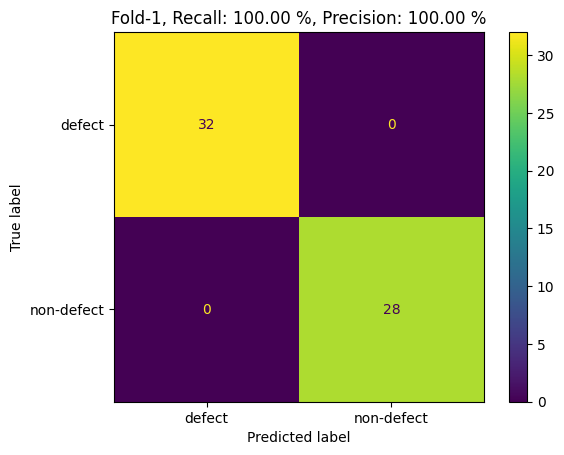

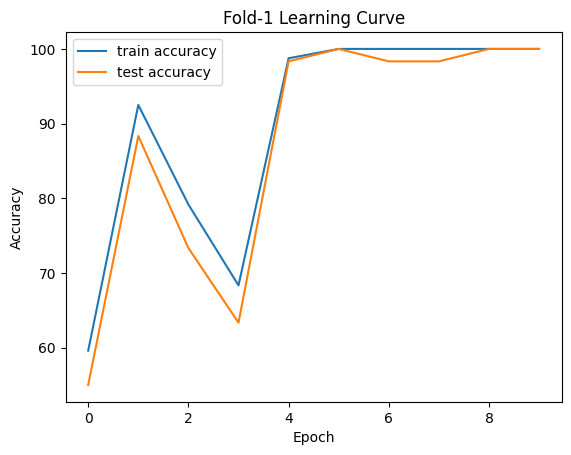

Start Fold-2 training
Fold [2/5], Epoch [1/10], Train Loss: 0.6648, Train Accuracy: 50.00, Test Accuracy: 50.00%
Fold [2/5], Epoch [2/10], Train Loss: 0.1059, Train Accuracy: 50.00, Test Accuracy: 50.00%
Fold [2/5], Epoch [3/10], Train Loss: 0.0449, Train Accuracy: 81.67, Test Accuracy: 73.33%
Fold [2/5], Epoch [4/10], Train Loss: 0.0253, Train Accuracy: 77.92, Test Accuracy: 66.67%
Fold [2/5], Epoch [5/10], Train Loss: 0.0135, Train Accuracy: 70.00, Test Accuracy: 61.67%
Fold [2/5], Epoch [6/10], Train Loss: 0.0075, Train Accuracy: 97.50, Test Accuracy: 85.00%
Fold [2/5], Epoch [7/10], Train Loss: 0.0050, Train Accuracy: 100.00, Test Accuracy: 98.33%
Fold [2/5], Epoch [8/10], Train Loss: 0.0039, Train Accuracy: 100.00, Test Accuracy: 98.33%
Fold [2/5], Epoch [9/10], Train Loss: 0.0027, Train Accuracy: 100.00, Test Accuracy: 98.33%
Fold [2/5], Epoch [10/10], Train Loss: 0.0022, Train Accuracy: 100.00, Test Accuracy: 100.00%


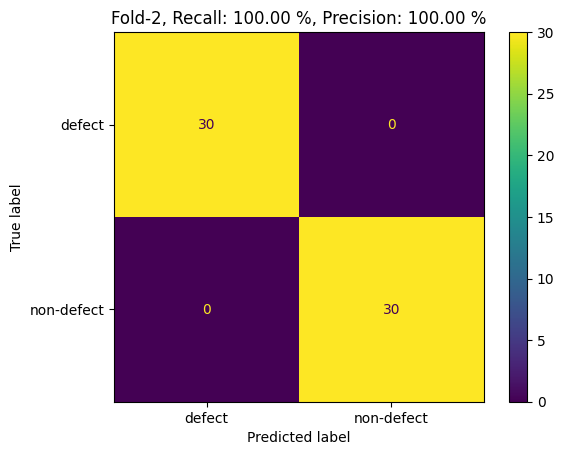

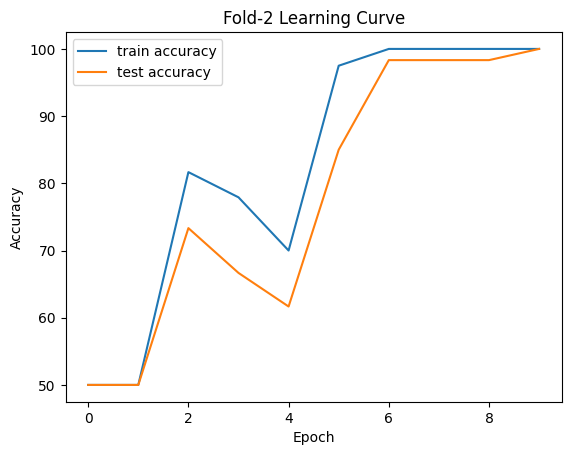

Start Fold-3 training
Fold [3/5], Epoch [1/10], Train Loss: 0.5611, Train Accuracy: 49.17, Test Accuracy: 53.33%
Fold [3/5], Epoch [2/10], Train Loss: 0.0604, Train Accuracy: 49.17, Test Accuracy: 53.33%
Fold [3/5], Epoch [3/10], Train Loss: 0.0303, Train Accuracy: 99.17, Test Accuracy: 95.00%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold [3/5], Epoch [4/10], Train Loss: 0.0348, Train Accuracy: 54.17, Test Accuracy: 46.67%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold [3/5], Epoch [5/10], Train Loss: 0.0155, Train Accuracy: 51.67, Test Accuracy: 46.67%
Fold [3/5], Epoch [6/10], Train Loss: 0.0129, Train Accuracy: 67.08, Test Accuracy: 65.00%
Fold [3/5], Epoch [7/10], Train Loss: 0.0086, Train Accuracy: 99.17, Test Accuracy: 100.00%
Fold [3/5], Epoch [8/10], Train Loss: 0.0059, Train Accuracy: 96.67, Test Accuracy: 95.00%
Fold [3/5], Epoch [9/10], Train Loss: 0.0038, Train Accuracy: 97.08, Test Accuracy: 96.67%
Fold [3/5], Epoch [10/10], Train Loss: 0.0048, Train Accuracy: 100.00, Test Accuracy: 98.33%


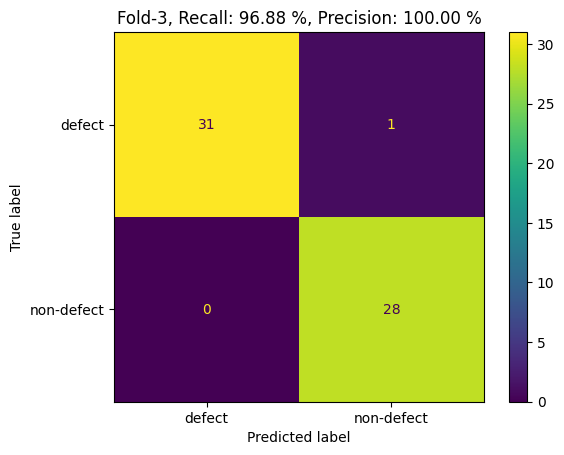

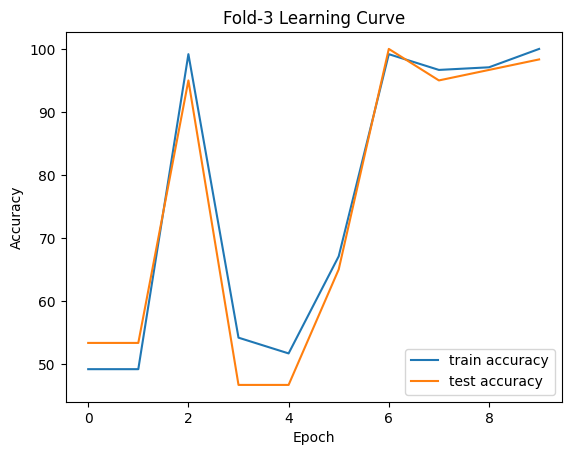

Start Fold-4 training
Fold [4/5], Epoch [1/10], Train Loss: 0.8651, Train Accuracy: 50.83, Test Accuracy: 46.67%
Fold [4/5], Epoch [2/10], Train Loss: 0.2408, Train Accuracy: 50.83, Test Accuracy: 46.67%
Fold [4/5], Epoch [3/10], Train Loss: 0.0962, Train Accuracy: 50.83, Test Accuracy: 46.67%
Fold [4/5], Epoch [4/10], Train Loss: 0.0555, Train Accuracy: 96.25, Test Accuracy: 100.00%
Fold [4/5], Epoch [5/10], Train Loss: 0.0328, Train Accuracy: 95.83, Test Accuracy: 98.33%
Fold [4/5], Epoch [6/10], Train Loss: 0.0259, Train Accuracy: 92.50, Test Accuracy: 95.00%
Fold [4/5], Epoch [7/10], Train Loss: 0.0113, Train Accuracy: 98.75, Test Accuracy: 100.00%
Fold [4/5], Epoch [8/10], Train Loss: 0.0079, Train Accuracy: 100.00, Test Accuracy: 100.00%
Fold [4/5], Epoch [9/10], Train Loss: 0.0047, Train Accuracy: 100.00, Test Accuracy: 100.00%
Fold [4/5], Epoch [10/10], Train Loss: 0.0250, Train Accuracy: 50.83, Test Accuracy: 46.67%


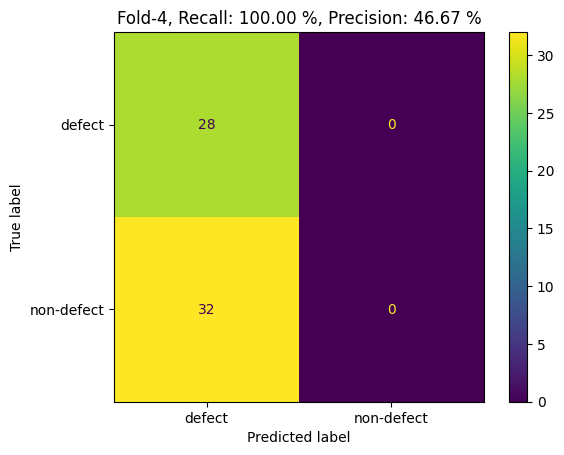

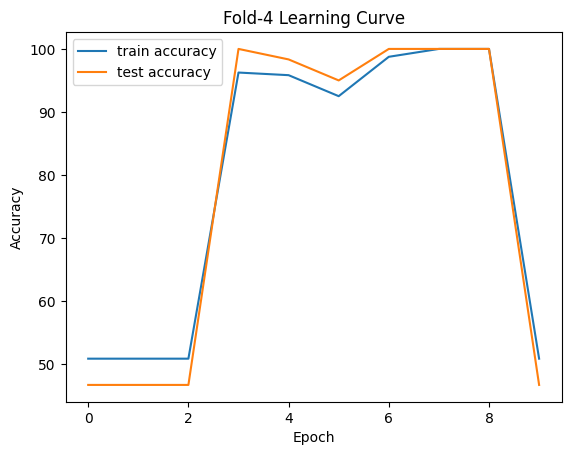

Start Fold-5 training
Fold [5/5], Epoch [1/10], Train Loss: 0.8378, Train Accuracy: 68.33, Test Accuracy: 75.00%
Fold [5/5], Epoch [2/10], Train Loss: 0.1933, Train Accuracy: 80.83, Test Accuracy: 81.67%
Fold [5/5], Epoch [3/10], Train Loss: 0.0928, Train Accuracy: 95.83, Test Accuracy: 95.00%
Fold [5/5], Epoch [4/10], Train Loss: 0.0510, Train Accuracy: 85.42, Test Accuracy: 83.33%
Fold [5/5], Epoch [5/10], Train Loss: 0.0355, Train Accuracy: 94.58, Test Accuracy: 93.33%
Fold [5/5], Epoch [6/10], Train Loss: 0.0259, Train Accuracy: 99.17, Test Accuracy: 95.00%
Fold [5/5], Epoch [7/10], Train Loss: 0.0444, Train Accuracy: 55.42, Test Accuracy: 55.00%
Fold [5/5], Epoch [8/10], Train Loss: 0.0455, Train Accuracy: 100.00, Test Accuracy: 100.00%
Fold [5/5], Epoch [9/10], Train Loss: 0.0348, Train Accuracy: 100.00, Test Accuracy: 100.00%
Fold [5/5], Epoch [10/10], Train Loss: 0.0374, Train Accuracy: 99.58, Test Accuracy: 100.00%


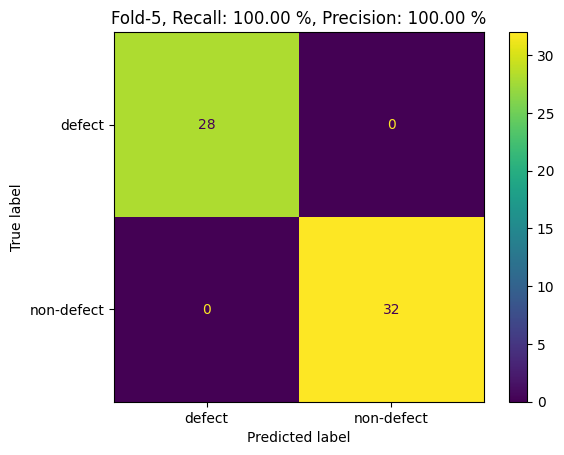

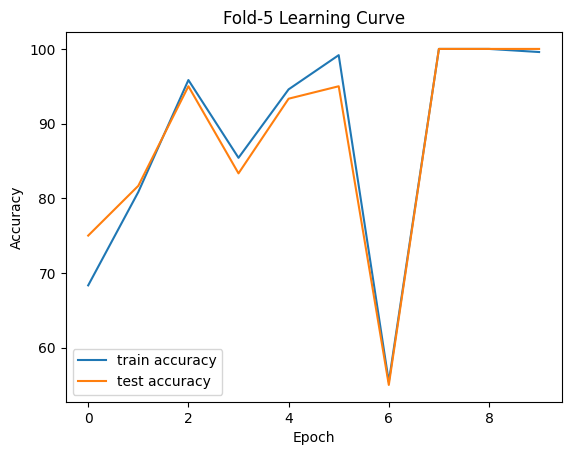

In [10]:
main()

# Call plot feature map function

Dimension of feature maps = (28, 512, 16, 16)
Plot feature maps of Image 0


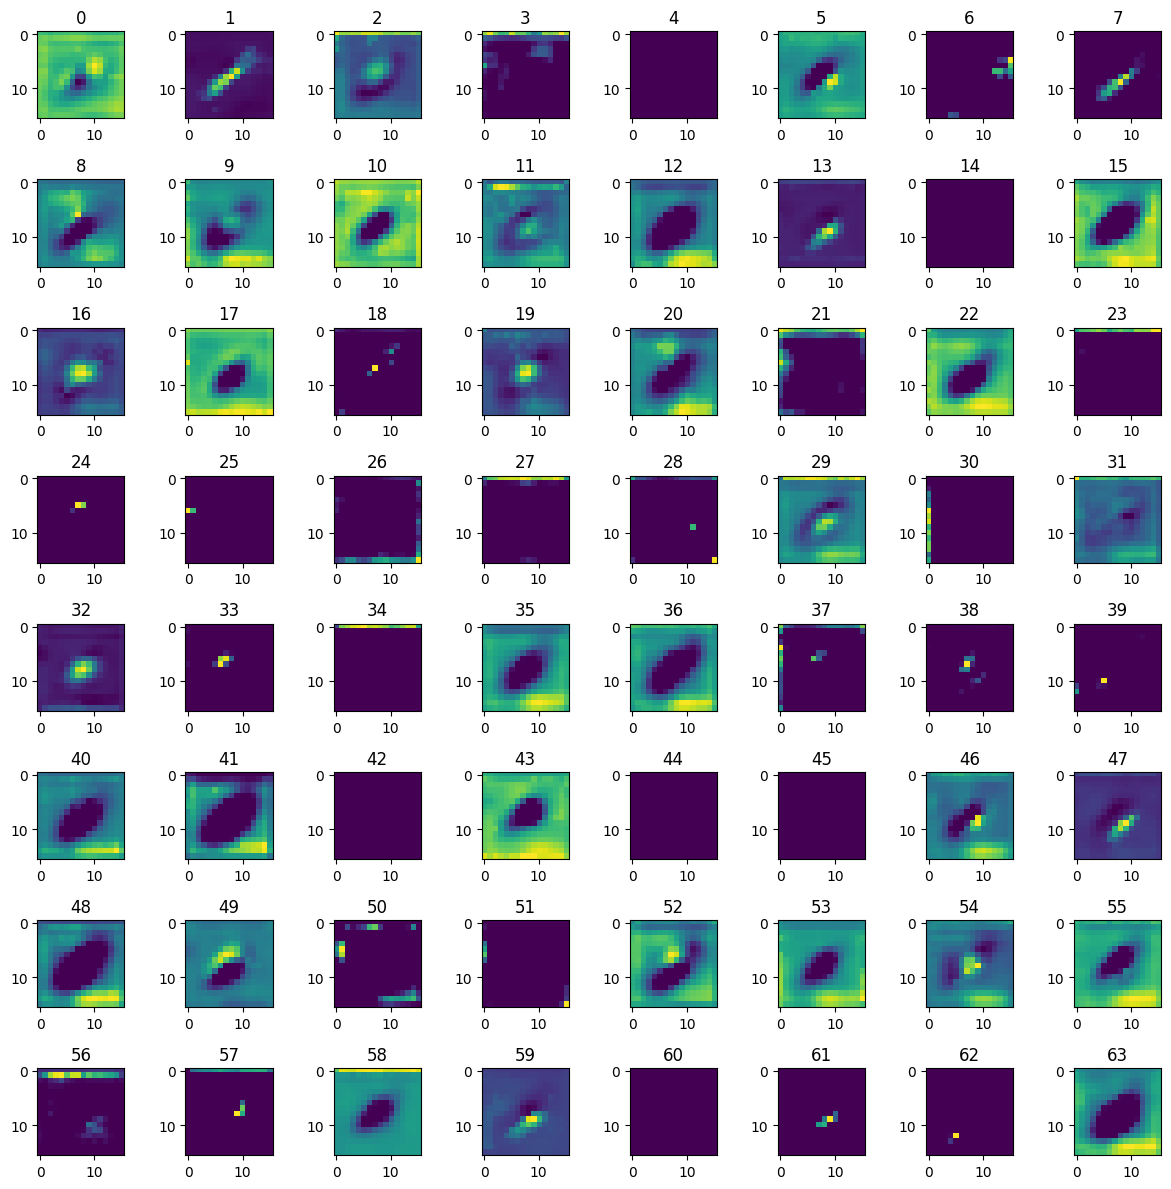

In [11]:
plot_feature_map(feature_maps, 0)